In [1]:
import warnings
warnings.filterwarnings('ignore')

# MNIST와 Scikit learn을 활용한 multiclass classification tutorial

## 1. Multiclass classifier
 - 다중 분류기
 - 둘 이상의 class를 구별
 - 다항 분류기(multinomial classifier) 라고도 한다.
 - RandomForest classifier, Naive bayes classifier 같은 알고리즘은 여러 개의 클래스를 직접 처리할 수 있음
 - SVM 또는 선형 분류기 같은 알고리즘은 이진 분류만 가능하기 때문에, 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음
  - One-versus-all, noe_versus-the-rest(OvA) 전략 : 클래스가 10개인 이미지 중에서 1개만 구분할 수 있는 숫자별 이진 분류기 10개를 훈련시킴. 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
  - One-versus-one(OvO) 전략 : 0/1, 0/2, 1/2 등 각 숫자의 조합마다 이진 분류기를 훈련. 클래스가 N개이면 분류기는 $\frac{N \times (N-1)}{2}$개가 필요함. 이미지 하나당 분류기를 모두 통과시킨 후 가장 많이 양성으로 분류된 클래스를 선택
  - Training set 크기에 민감한 알고리즘이라면 OvO가 선호되지만, 대부분 이진 분류 알고리즘에서는 OvA가 선호된다.

In [2]:
from keras.datasets import mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()

Using TensorFlow backend.


In [3]:
import numpy as np
from sklearn.linear_model import SGDClassifier

In [4]:
train_x_2d = np.reshape(train_x, (-1, 784))
test_x_2d = np.reshape(test_x, (-1, 784))

### 1.1 SGDClassifier를 이용한 multiclass classifier

In [5]:
# Sklearn에서는 multiclass classification에 대해서, binary classier를 사용하면 자동으로 OvA를 적용 (SVM의 경우에는 OvO 적용)
sgd = SGDClassifier(max_iter=5, random_state=42)
sgd.fit(train_x_2d, train_y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [6]:
sgd.predict([train_x_2d[2]])

array([4], dtype=uint8)

In [7]:
train_y[2]

4

In [8]:
# SGDClassifier에서는 총 10개의 점수를 계산하고, 그 중에서 가장 큰 값을 선택
sgd.decision_function([train_x_2d[2]])

array([[-500692.78550475, -347326.18447137,  -70123.9434253 ,
        -118834.02405971,  -30852.60840105, -580475.3268913 ,
        -605722.31629381, -257196.9939323 , -487325.63721432,
        -328932.10708509]])

Sklearn에서 OvO나 OvA를 사용하도록 강제하기 위해서는 OneVsOneClassifier나 OneVsRestClassifier를 사용

In [9]:
from sklearn.multiclass import OneVsOneClassifier
ovo_sgd = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_sgd.fit(train_x_2d, train_y)
ovo_sgd.predict([train_x_2d[2]])

array([4], dtype=uint8)

In [10]:
# OvO classifier 의 갯수
len(ovo_sgd.estimators_)

45

In [11]:
# Multiclass classifier의 성능
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, train_x_2d, train_y, cv=3, scoring='accuracy')

array([0.86872625, 0.87639382, 0.87848177])

성능을 올리기 위해서?
 - (원래 고려해야 했었던) feature scaling(normalization, standardization)을 사용

In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
train_x_2d_scaled = scaler.fit_transform(train_x_2d.astype(np.float64))  # Scaling
cross_val_score(sgd, train_x_2d_scaled, train_y, cv=3, scoring='accuracy')

array([0.90736853, 0.90884544, 0.91363705])

### 1.2 RandomForest를 이용한 multiclass classifier

- Randomforest 분류기는 샘플을 직접 다중 클래스로 분류할 수 있다. 따라서 별도로 OvO, OvA을 적용할 필요가 없다.

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(train_x_2d, train_y)

rf.predict([train_x_2d[2]])

array([4], dtype=uint8)

In [14]:
# 각 class 별 확률
rf.predict_proba([train_x_2d[2]])

array([[0. , 0. , 0. , 0.1, 0.9, 0. , 0. , 0. , 0. , 0. ]])

숫자 4일 확률이 100% 임을 나타낸다.

In [15]:
# 성능
cross_val_score(rf, train_x_2d, train_y, cv=3, scoring='accuracy')

array([0.9405119 , 0.93569678, 0.94149122])

In [16]:
# Tree는 scaling이 의미가 있을까?
cross_val_score(rf, train_x_2d_scaled, train_y, cv=3, scoring='accuracy')

array([0.93881224, 0.93629681, 0.93979097])

### 1-3. 에러 분석

데이터 준비 단계에서 가능한 선택사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 몇 개를 골라 `GridSearchCV`를 사용하여 하이퍼파라미터를 세밀하게 튜닝

즉, 가능성이 가장 높은 모델을 하나 찾았다고 가정할 때, 이 모델의 성능을 향상시킬 수 있는 방법은 무엇이 있을까? 

- 에러의 종류를 분석

In [17]:
from sklearn.model_selection import cross_val_predict

train_y_pred = cross_val_predict(sgd, train_x_2d_scaled, train_y, cv = 3)

In [18]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(train_y, train_y_pred)
confusion_mtx

array([[5726,    2,   26,   12,   11,   47,   47,    9,   39,    4],
       [   1, 6479,   42,   33,    8,   39,    8,    9,  113,   10],
       [  55,   35, 5319,  104,   79,   20,  106,   51,  174,   15],
       [  45,   40,  145, 5372,    3,  210,   33,   50,  135,   98],
       [  17,   26,   38,    8, 5361,    5,   57,   31,   86,  213],
       [  74,   38,   43,  199,   71, 4584,  116,   26,  175,   95],
       [  33,   22,   43,    2,   42,   90, 5640,    3,   43,    0],
       [  24,   23,   73,   29,   60,   12,    4, 5774,   18,  248],
       [  49,  165,   73,  150,   16,  153,   50,   24, 5038,  133],
       [  39,   31,   26,   92,  163,   35,    3,  177,   79, 5304]])

In [19]:
# 표를 쉽게 보기 위해서
import pandas as pd

confusion_mtx_df = pd.DataFrame(confusion_mtx)
confusion_mtx_df

,0,1,2,3,4,5,6,7,8,9
0,5726,2,26,12,11,47,47,9,39,4
1,1,6479,42,33,8,39,8,9,113,10
2,55,35,5319,104,79,20,106,51,174,15
3,45,40,145,5372,3,210,33,50,135,98
4,17,26,38,8,5361,5,57,31,86,213
5,74,38,43,199,71,4584,116,26,175,95
6,33,22,43,2,42,90,5640,3,43,0
7,24,23,73,29,60,12,4,5774,18,248
8,49,165,73,150,16,153,50,24,5038,133
9,39,31,26,92,163,35,3,177,79,5304


수치가 많을 때는 의미있는 시각화가 필요 (분석용으로)

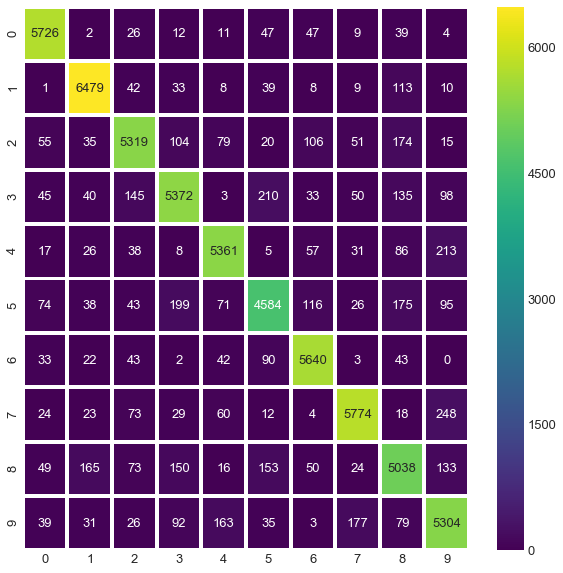

In [25]:
import seaborn as sns
sns.set({'figure.figsize': (10, 10), 'font.size': 13})

sns.heatmap(confusion_mtx_df, cmap='viridis', annot=True, linewidth=3, fmt='g')

- 행 : 실제 클래스, 열 : 예측한 클래스
- 밝은 칸 : 분류기가 이미지를 잘 분류
- 어두운 칸  : 분류기가 이미지를 제대로 분류하지 못하거나 숫자 이미지의 갯수가 적음
 - 이 부분을 정확하게 파악하기 위해서는 분류의 갯수가 아닌 분류 에러의 비율을 봐야 함

In [26]:
row_sums_df = confusion_mtx_df.sum(axis=1)
norm_conf_mtx_df = confusion_mtx_df / row_sums_df

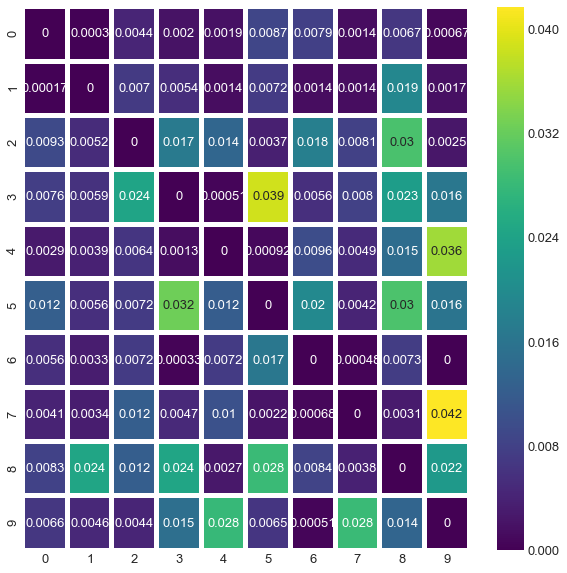

In [27]:
np.fill_diagonal(norm_conf_mtx_df.values, 0)
sns.heatmap(norm_conf_mtx_df, cmap='viridis', annot=True, linewidth=4)

분석 내용
- 밝은 쪽이 8행, 9행에 집중. 즉 다른 클래스로 자주 오분류 된다는 것을 의미
- 숫자 1은 대부분 정확하게 분류되었다고 볼 수 있음.
- 숫자 9를 8로 분류한 것과, 숫자 8을 9로 분류한 것의 오분류 비율이 다름 (2개의 숫자는 비슷하게 생김)

성능 향상을 위한 방안 예시
- 이미지를 8과 9라고 예측한 것이 다른 부분에 비해서 오분류가 많기 때문에(밝음) 이를 개선해야 함
 - 8, 9에 대한 training data를 더 수집
 - 8과 9가 다른 숫자들과 다른 특성들을 분류기에 추가
   - 동심원의 갯수 (8 : 1개, 9 : 1개, 5 : 0개 등)
 
 

In [23]:
# Helper 함수
import matplotlib as mpl

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [29]:
import matplotlib.pyplot as plt

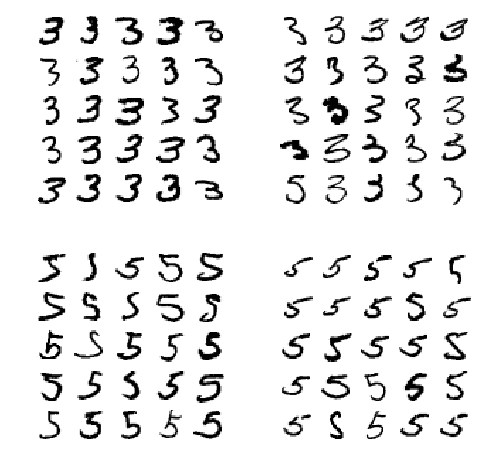

In [30]:
cl_a, cl_b = 3, 5

x_aa = train_x_2d[(train_y == cl_a) & (train_y_pred == cl_a)]
x_ab = train_x_2d[(train_y == cl_a) & (train_y_pred == cl_b)]
x_ba = train_x_2d[(train_y == cl_b) & (train_y_pred == cl_a)]
x_bb = train_x_2d[(train_y == cl_b) & (train_y_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(x_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(x_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(x_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(x_bb[:25], images_per_row=5)

SDG는 선형 모형이기 때문에 3, 5 처럼 몇 개의 픽셀만 다른 모델에 대해서는 쉽게 혼동할 수 밖에 없다. 이를 막기 위해서는 3과 5의 픽셀이 서로 치우쳐지지 않도록 전처리를 하는 방법이 있다.

## 2. Multilabel classifier (다중 레이블 분류)
 - 여러개의 binary label을 출력하는 분류 시스템
  - ex) 분류기의 입력이 사진이고, 분류기는 사람, 동물, 꽃을 인식하도록 훈련되었다고 가정할 때, 한 사진에 사람과 꽃이 있으면 [1, 0, 1]을 출력

In [31]:
train_y_large = (train_y >= 7)
train_y_odd = (train_y % 2 == 1)
y_multilabel = np.c_[train_y_large, train_y_odd]

In [32]:
# 첫 번째는 숫자가 큰 값(7, 8, 9)인지 나타내고 두 번째는 홀수인지를 나타냄
y_multilabel[1]

array([False, False])

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(train_x_2d, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [34]:
knn.predict([train_x_2d[1]])

array([[False, False]])

다중 레이블 분류기를 평가하는 방법
 - 각 레이블의 $F_1$ 점수를 구하고 간단하게 평균 점수를 계산

In [35]:
train_y_knn_pred = cross_val_predict(knn, train_x_2d, y_multilabel, cv=3, n_jobs=1)

In [36]:
from sklearn.metrics import f1_score

# 2개의 label (large number, odd number)에 같은 가중치를 준다.
f1_score(y_multilabel, train_y_knn_pred, average='macro')

0.976410265560605

## 3. Multioutput-multiclass classfication (다중 출력 다중 클래스 분류)
 - Multilabel classifier에서 한 label이 다중 클래스가 될 수 있도록 일반화한 classifier

이미지를 입력으로 받아서, 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
 - 1개의 entry가 1개의 label에 mapping 되고, 출력은 784 entries 이므로 즉 784개의 label을 출력하므로 multilabel
 - 1개의 label은 0~255 픽셀 강도를 가지고 있으므로 multiclass

In [37]:
# Noise를 추가한 이미지를 입력으로 사용
import random

noise = np.random.randint(0, 100, (len(train_x_2d), 784))  # 0 ~ 100의 noise가 더해진다.
train_x_mod = train_x_2d + noise
noise = np.random.randint(0, 100, (len(test_x_2d), 784))
test_x_mod = test_x_2d + noise
train_y_mod = train_x_2d  # y 값은 원래 이미지
test_y_mod = test_x_2d

In [38]:
knn.fit(train_x_mod, train_y_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [39]:
clean_digit = knn.predict([train_x_mod[1]])

In [42]:
# Help 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

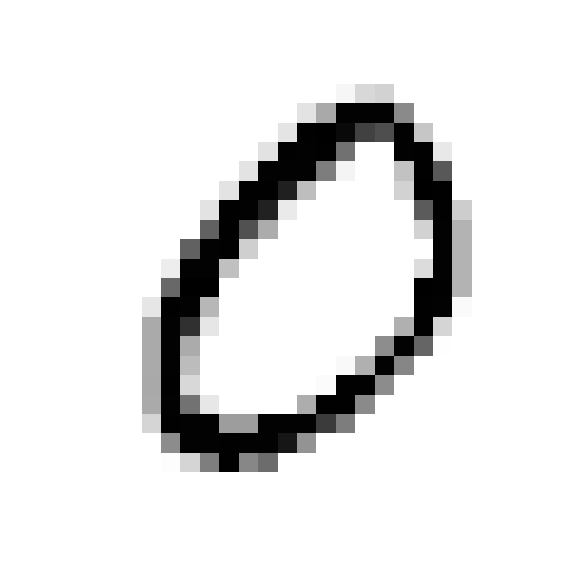

In [43]:
plot_digit(clean_digit)